# Motivation

This notebook aimns to dig into the architecture of the Gemma model, in order to takcle it.
Gemma model architecture is based on the transformer decoder by Vaswani et al (2017): [Gemma Model Card](https://www.kaggle.com/models/keras/gemma)

Do not hesiate to share any comment and/ or improving.

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 356)

import keras
import keras_nlp
import os

# Select a backend
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

2024-03-10 21:35:25.028155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 21:35:25.028305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 21:35:25.172851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Keras Gemma2b model
Loading Keras Gemma2b model and printing architecture....

In [3]:
gemma = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")

Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Let see how the model is based on summary() method:

In [4]:
gemma.summary(show_trainable=True)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape           ┃        Param # ┃ Connected to           ┃ Trainab… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ padding_mask (InputLayer)  │ (None, None)           │              0 │ -                      │    -     │
├────────────────────────────┼────────────────────────┼────────────────┼────────────────────────┼──────────┤
│ token_ids (InputLayer)     │ (None, None)           │              0 │ -                      │    -     │
├────────────────────────────┼────────────────────────┼────────────────┼────────────────────────┼──────────┤
│ gemma_backbone             │ (None, None, 2048)     │  2,506,172,416 │ padding_mask[0][0],    │    Y     │
│ (GemmaBackbone)            │                        │                │ token_ids[0][0]        │          │
├────────────────────────────┼────────────────────────┼────────────────┼────────────────────────┼──────────┤
│ token_embedding            │ (None, None, 256000)   │    524,288,000 │ gemma_backbone[0][0]   │    Y     │
│ (ReversibleEmbedding)      │                        │                │                        │          │
└────────────────────────────┴────────────────────────┴────────────────┴────────────────────────┴──────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

# Architecture Model Findings

**GemmaTokenizer**

**Objetive**: Converts strings to sequences of token ids.
* The raw bytes of a string are too high dimensional to be useful features so we first map them to a small number of tokens, that creates a vocabulary of 256k sizing. 

**GemmaPreprocessor**

**Objetive**: Gemma preprocessing layer which tokenizes and packs inputs.
* Converts strings to a dictionary of preprocessed tensors consumed by the backbone, starting with tokenization.  * Each model uses special tokens and extra tensors to understand the input such as delimiting input segments and identifying padding tokens. Padding each sequence to the same length improves computational efficiency.

**GemmaBackbone**

**Objetive**:: Converts preprocessed tensors to dense features. Does not handle strings; call the preprocessor first.
* The backbone distills the input tokens into dense features that can be used in downstream tasks. It is generally pretrained on a language modeling task using massive amounts of unlabeled data. Transferring this information to a new task is a major breakthrough in modern NLP.
* Gemma core network with hyperparameters. This backbone implements the base Transformer network for the Gemma model. It includes the embedding lookups and transformer layers. This backbone will output the final hidden states for each token, not generative predictions over the vocabulary space.
* Shape of the output tensor from GemmaBackBone layer: **2048**
* As you can see from the summary, the gemma model has **2.5 billion** trainable **parameters**.
* Shape of the output tensor from ReversibleEmbedding layer: **256k** equals to the vocabulary size of **GemmaTokenizer**



# Accessing Layers

In [5]:
# Accessing layers
for layer in gemma.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.input_spec)

padding_mask True float32 None
token_ids True float32 None
gemma_backbone True float32 [InputSpec(shape=(None, None), ndim=2), InputSpec(shape=(None, None), ndim=2)]
token_embedding True float32 None


Accessing Layer Weights:

In [6]:
# Accessing layer weights
for layer in gemma.layers:
    weights = layer.get_weights()
    print(layer.name)
    for w in weights:
        print(w.dtype, w.shape, w.size)

padding_mask
token_ids
gemma_backbone
float32 (256000, 2048) 524288000
float32 (2048,) 2048
float32 (8, 2048, 256) 4194304
float32 (1, 2048, 256) 524288
float32 (1, 2048, 256) 524288
float32 (8, 256, 2048) 4194304
float32 (2048,) 2048
float32 (2048, 16384) 33554432
float32 (2048, 16384) 33554432
float32 (16384, 2048) 33554432
float32 (2048,) 2048
float32 (8, 2048, 256) 4194304
float32 (1, 2048, 256) 524288
float32 (1, 2048, 256) 524288
float32 (8, 256, 2048) 4194304
float32 (2048,) 2048
float32 (2048, 16384) 33554432
float32 (2048, 16384) 33554432
float32 (16384, 2048) 33554432
float32 (2048,) 2048
float32 (8, 2048, 256) 4194304
float32 (1, 2048, 256) 524288
float32 (1, 2048, 256) 524288
float32 (8, 256, 2048) 4194304
float32 (2048,) 2048
float32 (2048, 16384) 33554432
float32 (2048, 16384) 33554432
float32 (16384, 2048) 33554432
float32 (2048,) 2048
float32 (8, 2048, 256) 4194304
float32 (1, 2048, 256) 524288
float32 (1, 2048, 256) 524288
float32 (8, 256, 2048) 4194304
float32 (2048,)

# Accessing Model Parameters
You can access the model's parameters directly using the get_config() method.

In [7]:
# Accessing model parameter
model_config = gemma.get_config()
print(model_config)


{'backbone': {'module': 'keras_nlp.src.models.gemma.gemma_backbone', 'class_name': 'GemmaBackbone', 'config': {'name': 'gemma_backbone', 'trainable': True, 'vocabulary_size': 256000, 'num_layers': 18, 'num_query_heads': 8, 'num_key_value_heads': 1, 'hidden_dim': 2048, 'intermediate_dim': 32768, 'head_dim': 256, 'layer_norm_epsilon': 1e-06, 'dropout': 0}, 'registered_name': 'keras_nlp>GemmaBackbone', 'build_config': {'input_shape': None}}, 'preprocessor': {'module': 'keras_nlp.src.models.gemma.gemma_causal_lm_preprocessor', 'class_name': 'GemmaCausalLMPreprocessor', 'config': {'name': 'gemma_causal_lm_preprocessor', 'trainable': True, 'dtype': 'float32', 'tokenizer': {'module': 'keras_nlp.src.models.gemma.gemma_tokenizer', 'class_name': 'GemmaTokenizer', 'config': {'name': 'gemma_tokenizer', 'trainable': True, 'dtype': 'int32', 'proto': None, 'sequence_length': None}, 'registered_name': 'keras_nlp>GemmaTokenizer'}, 'sequence_length': 8192, 'add_start_token': True, 'add_end_token': True}

Accessing Layer Output: You can obtain the output of intermediate layers using the predict() method or by creating a new Keras model that outputs the activations of specific layers.

# Plotting the loading model

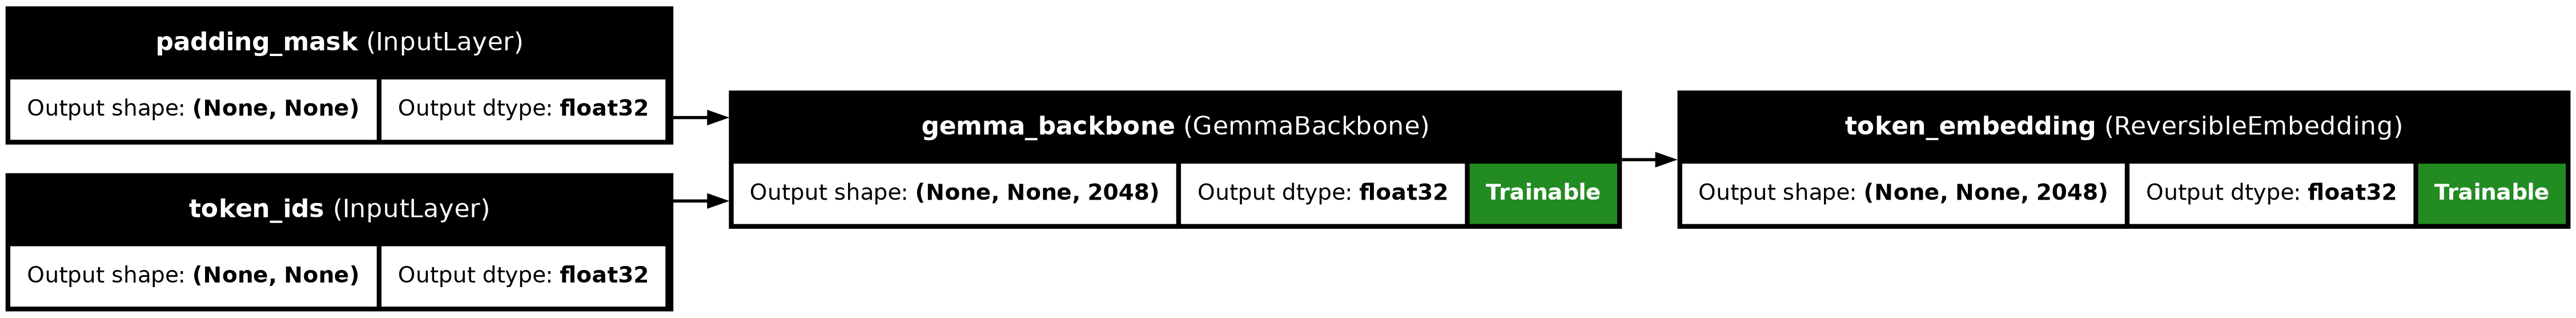

In [8]:
rankdir='LR'
keras.utils.plot_model(gemma, show_shapes=True, show_dtype=True, show_layer_names=True, rankdir=rankdir, show_trainable=True)

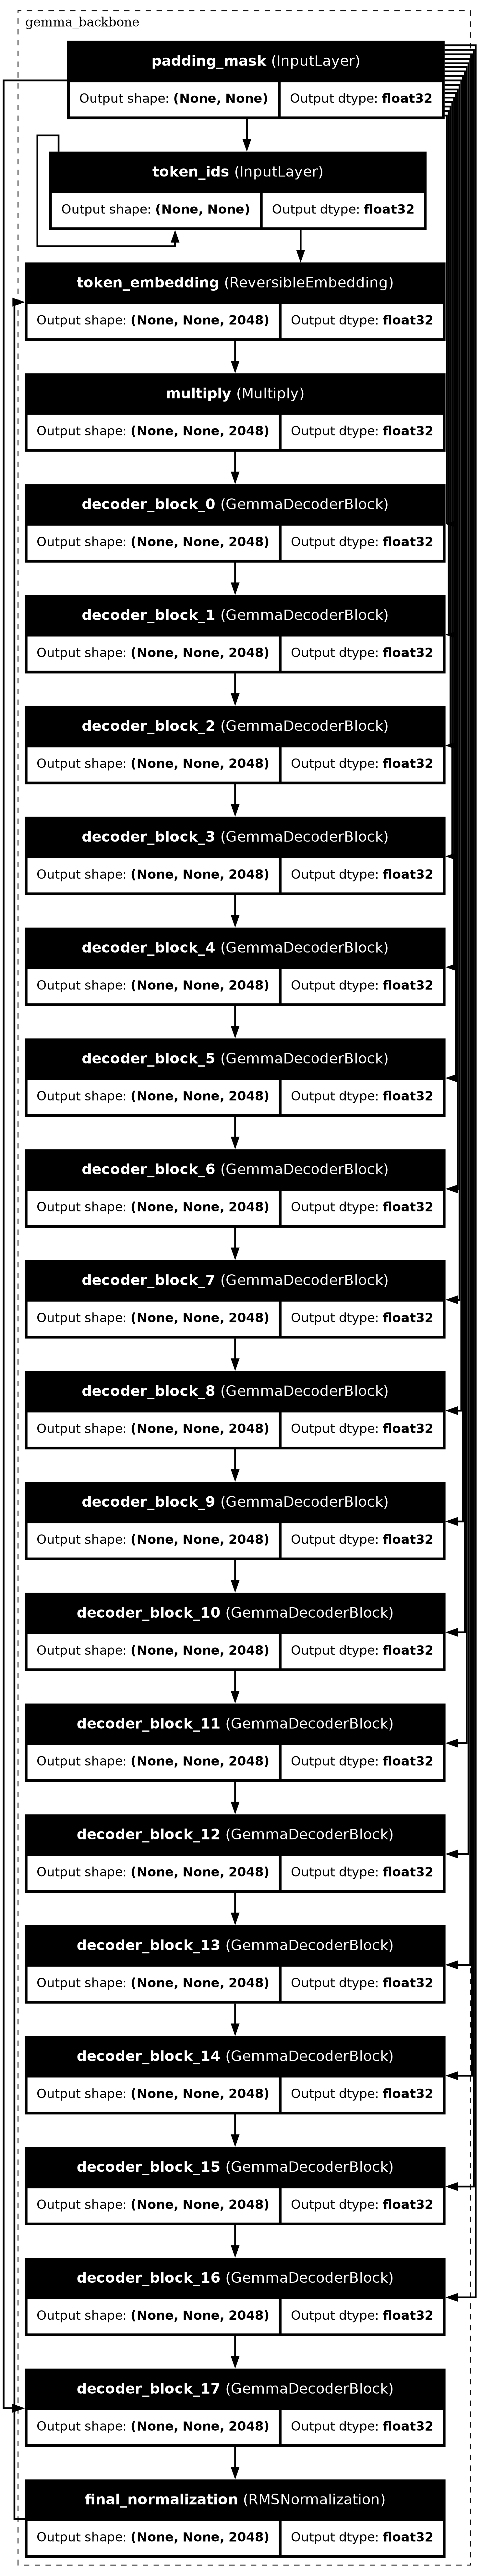

In [9]:
# expand_nested: whether to expand nested Functional models into clusters.
rankdir='TB'
keras.utils.plot_model(gemma, show_shapes=True, show_dtype=True, show_layer_names=True, rankdir=rankdir, expand_nested=True)